In [216]:
import math

import matplotlib.pyplot as plt
import numpy as np
import os
import time

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
import qiskit as qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile, Aer, IBMQ

import ramsey_experiment

# Loading your IBM Quantum account(s)
IBMQ.save_account(os.environ.get('IBM_KEY'), overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')



ibmqfactory.load_account:WARNING:2024-01-24 15:53:20,528: Credentials are already in use. The existing account in the session will be replaced.


In [65]:
import Ramsey_ExperimentV2
import random
import importlib
from tqdm import tqdm

ramsey_experiment = importlib.reload(Ramsey_ExperimentV2)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch

h = lambda n, J, z: sum([J[i] * (z[i] - 1) * (z[(i + 1) % n] - 1) for i in range(n - 1)])
y_lornz = lambda a, x, w: np.pi * (2 * a / (a ** 2 + (x - w) ** 2) + 2 * a / (a ** 2 + (x + w) ** 2))
y_lornz_single = lambda a, x, w: (2 * a / ((a ** 2 + x ** 2) * 2 * np.pi))


def sinc(x_values):
    X = []
    for x in x_values:
        X.append((np.sin(2 * x * np.pi) / (2 * x * np.pi) if x != 0 else 1))
    return X


def fisher_inf(x, w, a):
    cos_wx_squared = np.cos(w * x) ** 2
    sin_wx_squared = np.sin(w * x) ** 2
    exp_ax = np.exp(a * x)

    term1 = x ** 2 * cos_wx_squared / (exp_ax + np.cos(w * x)) ** 2
    term2 = x ** 2 * sin_wx_squared / (exp_ax + np.cos(w * x)) ** 2

    return term1 + term2


def effective_hem(size, J, W):
    hem = np.zeros((2 ** size, 2 ** size))
    for i in range(2 ** size):
        binary = '{0:b}'.format(i).zfill(size)
        Z = [(-1) ** int(i) for i in binary]
        #Z.reverse()
        hem[i, i] = h(size, J, Z)
        hem[i, i] += sum([W[k] for k in range(size) if binary[k] == '1'])
    return hem

In [64]:
import numpy as np
import math

n = 1
T = np.pi
shots = 100
measurements = 50
delay = np.linspace(0, T, measurements)

W = [random.gauss(3, 1) for _ in range(n)]
L = [random.gauss(1, 1) for _ in range(n)]
J = [random.gauss(3, 1) for _ in range(n - 1)]

L = [3.2]

W = [3]
J = [0, 1]

total_shots = shots * measurements
fisher_values = [fisher_inf(t, W[0], L[0]) for t in delay]
Shots = [math.ceil(total_shots * fisher_values[i] / sum(fisher_values)) for i in range(measurements)]
Shots = [Shots[i] if Shots[i] > 0 else 1 for i in range(measurements)]

print("J = ", J)
print("W = ", W)

batch1 = []
batch2 = []

exp = []
W_estimate = 10
L_estimate = 1
time_measured = []
for i in tqdm(range(measurements), desc="Creating experiments"):
    current_fisher = fisher_inf(delay, W_estimate, L_estimate)
    best_t = np.argmax(current_fisher)
    exp.append(RamseyExperiment(n, delay[best_t], 100, J, W, L))
    exp.append(RamseyExperiment(n, delay[i], Shots[i], J, W, L))
    exp[i].create_circuit_detuning()
    exp[i].add_decay_raw()
    batch1.append(exp[i])
    W_estimate = RamseyBatch(batch1).fit_to_theory()[0][1]
    L_estimate = RamseyBatch(batch1).fit_to_theory()[0][0]
    time_measured.append(delay[best_t])
print("W_estimate = ", W_estimate)
print("L_estimate = ", L_estimate)

print("time_measured = ", time_measured)

J =  [0, 1]
W =  [3]


Creating experiments: 100%|██████████| 50/50 [00:00<00:00, 135.24it/s]

W_estimate =  2.742538688413996
L_estimate =  3.0704848695292957
time_measured =  [2.0516523452014974, 0.0641141357875468, 2.6286795672894185, 2.5645654315018716, 2.6286795672894185, 2.821021974652059, 2.500451295714325, 2.500451295714325, 1.0258261726007487, 1.7310816662637634, 1.4105109873260295, 1.4105109873260295, 1.3463968515384828, 1.3463968515384828, 1.218168579963389, 1.218168579963389, 1.2822827157509358, 1.218168579963389, 1.0899403083882955, 0.7693696294505615, 0.7052554936630148, 0.7052554936630148, 0.7052554936630148, 0.7052554936630148, 0.7052554936630148, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6

In [204]:
import numpy as np
from scipy.optimize import minimize


# Define the function
def vw(t, a, w):
    t1, t2 = t
    term1 = np.exp(2 * a * t1) * t2 ** 2 * np.cos(t2 * w) ** 2
    term2 = 2 * np.exp(a * t1) * t2 ** 2 * np.cos(t1 * w) * np.cos(t2 * w) ** 2
    term3 = np.cos(t1 * w) ** 2 * (np.exp(2 * a * t2) * t1 ** 2 + 2 * np.exp(a * t2) * t1 ** 2 * np.cos(t2 * w) + (
                t1 ** 2 + t2 ** 2) * np.cos(t2 * w) ** 2)
    term4 = (1 / np.sin((t1 - t2) * w)) ** 2
    return (term1 + term2 + term3) * term4 / (t1 ** 2 * t2 ** 2)


# Constants
a = 1.4
w = 3

# Constraints
cons = ({'type': 'ineq', 'fun': lambda t: t[0] - t[1]},  # t1 > t2
        {'type': 'ineq', 'fun': lambda t: t[0]},  # t1 > 0
        {'type': 'ineq', 'fun': lambda t: t[1] - 1})  # t2 > 1

# Initial guess
initial_guess = [3, 3]

# Optimization
result = minimize(vw, initial_guess, args=(a, w), constraints=cons, method='SLSQP')

if result.success:
    optimized_t1, optimized_t2 = result.x
    print("Minimum at t1 =", optimized_t1, "t2 =", optimized_t2)
    print("Minimum value of vw:", result.fun)
else:
    print("Optimization failed:", result.message)


Optimization failed: Inequality constraints incompatible


C:\Users\user\AppData\Local\Temp\ipykernel_7572\3017969988.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  term4 = (1 / np.sin((t1 - t2) * w))**2


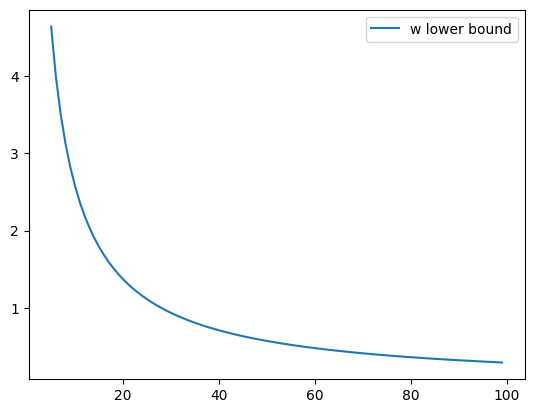

In [297]:
def p(t, w, a):
    return 1 / 2 * (1 + np.cos(w * t)) * np.exp(-a * t)


def pw(t, w, a):
    return - 1 / 2 * t * np.sin(w * t) * np.exp(-a * t)


def pww(t, w, a):
    return - 1 / 2 * t ** 2 * np.cos(w * t) * np.exp(-a * t)


def pa(t, w, a):
    return - 1 / 2 * t * np.cos(w * t) * np.exp(-a * t)


def paa(t, w, a):
    return 1 / 2 * t ** 2 * np.cos(w * t) * np.exp(-a * t)


def paw(t, w, a):
    return 1 / 2 * t ** 2 * np.sin(w * t) * np.exp(-a * t)


def fisher_matrix(t, w, a, shots):
    Iww = 0
    Iaa = 0
    Iwa = 0

    for i in range(len(t)):
        p0 = p(t[i], w, a)
        p1 = 1 - p0
        pw0 = pw(t[i], w, a)
        pw1 = -pw0
        pww0 = pww(t[i], w, a)
        pww1 = -pww0
        pa0 = pa(t[i], w, a)
        pa1 = -pa0
        paa0 = paa(t[i], w, a)
        paa1 = -paa0
        paw0 = paw(t[i], w, a)
        paw1 = -paw0

        if p0 == 0:
            p0 = 1e-10
        if p1 == 0:
            p1 = 1e-10

        Iww -= shots[i] * (p0 * ((pww0 * p0 - pw0 ** 2) / p0 ** 2) + p1 * ((pww1 * p1 - pw1
                                                                            ** 2) / p1 ** 2))
        Iaa -= shots[i] * (p0 * ((paa0 * p0 - pa0 ** 2) / p0 ** 2) + p1 * ((paa1 * p1 - pa1 ** 2) / p1 ** 2))
        Iwa -= shots[i] * (p0 * ((paw0 * p0 - pw0 * pa0) / p0 ** 2) + p1 * ((paw1 * p1 - pw1 * pa1) / p1 ** 2))

    return np.array([[Iww, Iwa], [Iwa, Iaa]])

def lower_bound(f_mat):
    inv = np.linalg.inv(f_mat)
    w_var = inv[0, 0]
    a_var = inv[1, 1]
    return w_var, a_var

T =  0.2*np.pi
shots = 100
measurements = np.arange(5, 100)
w = 3
decay = 3.2
w_bounds = []
a_bounds = []
for m in measurements:
    delay = np.linspace(0, T, m)
    Shots = len(delay) * [shots]
    fisher = fisher_matrix(delay, w, decay, Shots)
    w_bound, a_bound = lower_bound(fisher)
    w_bounds.append(100 * w_bound/w)
    a_bounds.append(100 * a_bound/a)


from matplotlib import ticker
#plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.plot(measurements, w_bounds, label="w lower bound")
#plt.plot(measurements, a_bounds, label="a lower bound", color="orange")
#plt.semilogy()
#plt.ylim([0, 10])
#plt.xlim([0, 20])
plt.legend()